## Names of group members (max 3):
    
    Kevin Vonk, s1706896



## Assignment 3 Part 1. Support Vector Machines

In [111]:
import numpy as np
import math
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt

# I need to do this because I am abusing numpy, and I need to catch a specific error
# This might not be the best way to go around it, but it works for me.
np.seterr(all="raise")

def F(x):
    ## the function that should be maximized
    fitness = -(x[:, 0]-1)**2 - (x[:, 0]-x[:, 1])**2 - (x[:, 0]-x[:, 1]-x[:, 2]-2)**2
    return fitness

We define $K$ vectors ${\bf{x}}_k$, $k=0, \ldots, K-1$ that serve all as approximations of the real maximum. Every vector in this collection has a certain fitness $f_k = F({\bf{x}}_k)$. We will apply a genetical algortithm in this notebook, in which each ${\bf{x}}_k$ is an **indiviual**.

For the time being assume these vectors are sorted according decreasing fitness. So ${\bf{x}}_0$ has the largest fitness $f_0$ and ${\bf{x}}_{K-1}$ the lowest $f_{K-1}$. Genetically the vector ${\bf{x}}_0$ is stronger ${\bf{x}}_1$, etc.

After initializing a population with random **genomes** and sorting them according to fitness, we are going to generate a new population, again of size $K$. (You will see that there are quite some choices to be made in the sequal, but, strangely enough, it does not matter so much how you choose them: this genetic algorithm works 'all the time'.) 

<ul>
    <li>
        First of all, we are going to recombine individuals $A, B$, from the current population to new individuals 
        $C$ with different genomes. function cross; 
    </li>
    <li>
        Moreover mutation is assumed to happen as well: function mutate. 
    </li> 
</ul>
In the functions below there are two numbers, $a$ and $b$, to play with. But the GA is so nice: try to come up with an alternative!

In [112]:
def cross(A, B):
    rng = np.random.default_rng()
    dim = A.shape
    C = np.ndarray(dim)
    ## take a random pick of dimension / 2 from A, the others from B
    keys = rng.choice([True, False], size=dim)

    try:
        C[keys] = A[keys]
        C[~keys] = B[~keys]
    except IndexError:
        print(f"Shape A:{dim}, Shape B: {B.shape}, Shape C: {C.shape}, Shape keys: {keys.shape}")
        raise

    return C

def mutate(C, replace=False):
    rng = np.random.default_rng()
    dim = C.shape
    a = 2
    b = 0.25
    offset = -1

    D = copy.deepcopy(C)
    ## for every gen take a b% chance to change the gen with a random value with amplitude a
    keys = rng.choice([True, False], size=dim, p=[b, 1-b])
    vals = a * rng.random(size=dim) + offset

    if replace:
        D[keys] = vals[keys]
    else:
        D[keys] += vals[keys]
    
    return D

These functions allow us to combine genomes of individuals. We of course now need a strategy **which individuals** are going to take part in it. As a first attempt, lets test the following genetic algorithm:

As the individuals with a low index are strong, we let the strongest $25\%$ be part of the new population as well.

For the other $75\%$ we are going to combine the genomes of two parents, $A, B$, giving an individual $C$ with  
        
            A = X_k, B = X_{k+1},   k=0, ..,K/4 - 1, so 25%
            A = X_k, B = X_r,   k=0, .., K/4 -1, r random, so 25% 
            A = X_r, B = X_s,   r, s both random, K/4 times, so 25% 

For convenience we take $K$ to be a multiple of $4$, $N=K/4$. And again: change the rules and see if you can do better than my first attempt!

The resulting algorithm may seem to be slow. However, if the number of parameters becomes (much) larger the algorithm still works more or less at the same speed.

In [113]:
def cross_and_mutate(pop, pop_size):
    rng = np.random.default_rng()
    ## pop describes the complete population: 
    ## numbers of individuals is
    size_population = pop_size[0]
    N = int(size_population/4)
    dimension = pop_size[1] 

    keys = rng.integers(0, size_population, size=(N, 3))

    try:
        offspring = copy.deepcopy(pop)
        offspring[N:2*N] = cross(pop[0:N], pop[1:N+1])
        offspring[2*N:3*N] = cross(pop[0:N], pop[keys[:, 0]])
        offspring[3*N:] = cross(pop[keys[:, 1]], pop[keys[:, 2]])
    except:
        print(f"{keys}, {keys.shape}")
        raise

    offspring[N:] = mutate(offspring[N:])

    return offspring

In [114]:
def run(N = 6, dimension = 3, num_generations = 10000):
    rng = np.random.default_rng()
    AMP = 2
    OFFSET = -1

    size_population = 4 * N
    pop_size = (size_population, dimension)
    new_population = AMP * rng.random(size=pop_size) + OFFSET
    fitness = F(new_population)

    J = np.ndarray(num_generations) ## stores the history of the fitness
    for generation in range(num_generations):
        ## compute the fitness of each individual
        ## sort this such that the best is on top, etc 
        ## help: argsort
        fitness = F(new_population)
        # Sort keys by fitness. Since we want the highest fitness at index 0,
        # we must revert the array (np.argsort sorts by ascending value)
        sorted_keys = np.argsort(fitness)[::-1]
        fitness = fitness[sorted_keys]
        new_population = new_population[sorted_keys, :]

        J[generation] = fitness[0]
        offspring_crossover = cross_and_mutate(new_population, pop_size)
        new_population = offspring_crossover

    return fitness[0], new_population[0], J

Ended with fitness=-0.00 and a genome of [ 1.  1. -2.]


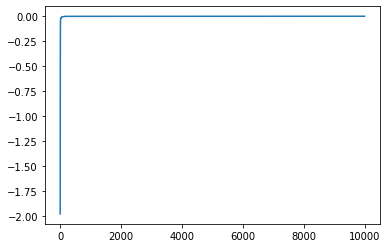

In [115]:
fitness, sol, J = run()
plt.plot(J)

with np.printoptions(precision=2, suppress=True):
    print(f"Ended with fitness={fitness:.2f} and a genome of {sol}")

This should converge to fitness = 0 best genome = [ 1, 1, -2 ]

**We have now setup the algorithm an now apply it to data sets:**

<ul>
    <li>
        The first we do by using a package **sklearn**; and also by using the genetic algorithm. 
    </li>
    <li>
        Later on you will use the package **sklearn** on more difficult data sets (to write a code that does what **sklearn** can do will take many ECs....
    </li>
</ul>


In [116]:
from scipy.io import loadmat
from sklearn.svm import SVC

The data sets below will be data in 2D with two types: $y=1$ and $y=0$ (or $-1$). 

In [117]:
def plotData(X, y):
    pos = (y == 1).ravel()
    neg = (y <= 0).ravel()    
    plt.scatter(X[pos,0], X[pos,1], s=60, c='k', marker='+', linewidths=1)
    plt.scatter(X[neg,0], X[neg,1], s=60, c='y', marker='o', linewidths=1)

In [118]:
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)
    plotData(X, y)
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='|', s=100, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

### Example Dataset 1

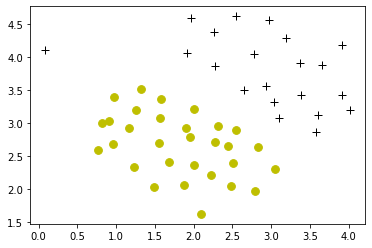

In [119]:
data1 = loadmat('../data/ex6data1.mat')
## this data sets contains 51 points, the last one has the lowest x_1 value
z1 = data1['y']
X1 = data1['X']
y1 = np.ndarray(z1.size)

keys = (z1 == 0).flatten()
y1[keys] = -1
y1[~keys] = 1

plotData(X1, y1) 

We first make the data set a little simpler: the point on the left changes identity ($1 \to -1$)

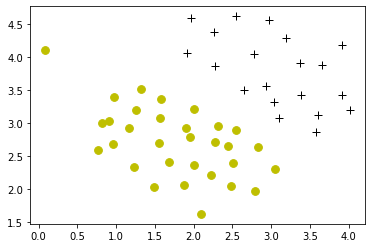

In [120]:
y1[50] = -1
plotData(X1, y1)      

This is what SVC from the package does

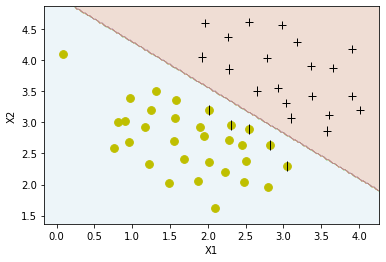

Number of support vectors:  10


In [121]:
clf = SVC(C=1.0, kernel='linear')
clf.fit(X1, y1.ravel())
plot_svc(clf, X1, y1)

**Implement the optimalisation as as defined in Eq. (4.12) in the lecture notes, ie. (7.3) in Bishop, using the genetic algorith that we already have in the run() function.**

In [190]:
def F(w): ## The fitness function is the term between the argmax{..} 
              ## of eq. (4.11) in the lecture notes or (7.3) in Bishop.
              ## read argmax{ F(inidivual) }

    PENALTY = -1000
    # This is really bad practice.
    x = X1
    y = y1

    fitness = []

    for weight in w:
        gamma = y * (weight[:-1] @ x.T + weight[-1])
        keys = gamma < 0

        gamma[keys] = np.nan
        gamma = np.nanmin(gamma)
        if np.isnan(gamma):
            gamma = len(keys) * PENALTY

        #fitness.append(gamma / np.linalg.norm(w[:-1]) + np.count_nonzero(keys) * PENALTY)
        fitness.append(gamma + np.count_nonzero(keys) * PENALTY)
    
    fitness = np.array(fitness)

    # print(w.T.shape)
    # print(x.shape)

    # temp = w[:, 1:].T @ x + w[:, 0]
    # print(temp.shape)

    # gamma = y * (w[:, 1:] @ x.T + w[:, 0])

    # # Lets abuse NaN!
    # gamma[gamma < 0] = np.nan
    # try:
    #     gamma = np.nanmin(gamma, axis=1)
    # except:
    #     # We have some NaNs, deal with them
    #     print("nans were dealt with")
    # gamma[np.isnan(gamma)] = -999


    # #gamma = gamma[gamma >= 0]
    # #if len(gamma) == 0:
    # #    gamma = -999
    # #else:
    # #    assert np.all(gamma >= 0), "Incorrect classification"
    # #gamma = np.abs(gamma)  # This makes it even worse 

    # #fitness = np.min(gamma) / np.linalg.norm(w[:, 1:], axis=1)
    # fitness = gamma / np.linalg.norm(w[:, 1:], axis=1)

    if fitness.shape[0] != w.shape[0]:
        raise Exception(f"Normed over wrong axis. {fitness.shape}, {w.shape}")

    return fitness

fitness, sol, J = run(num_generations=1000) ## you can reduce the number of generations: run(6, 3, 1000)
with np.printoptions(precision=2, suppress=True):
    print(f"Ended with fitness={fitness:.2f} and a genome of {sol}")

Ended with fitness=0.14 and a genome of [ 0.33  0.51 -2.44]


In [193]:
def plotData2(X, y, sol):
    pos = (y == 1).ravel()
    neg = (y == -1).ravel()    
    plt.scatter(X[pos,0], X[pos,1], s=60, c='k', marker='+', linewidths=1)
    plt.scatter(X[neg,0], X[neg,1], s=60, c='y', marker='o', linewidths=1)  
    x = np.linspace(0, 4, 100)
    plt.plot(x, -(sol[0] * x + sol[2])/sol[1], linestyle='solid')
    plt.plot(x, -(sol[0] * x + sol[2] + fitness)/sol[1], linestyle='solid')
    plt.plot(x, -(sol[0] * x + sol[2] - fitness)/sol[1], linestyle='solid')

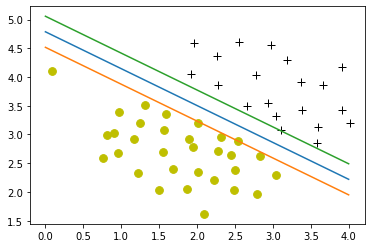

In [194]:
plotData2(X1, y1, sol)

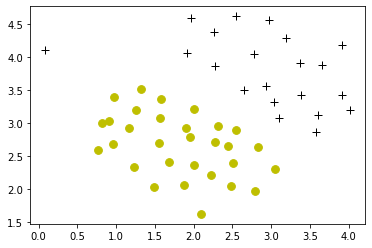

In [195]:
y1[50] = 1
plotData(X1, y1) 

In [197]:
fitness, sol, J = run(num_generations=1000)

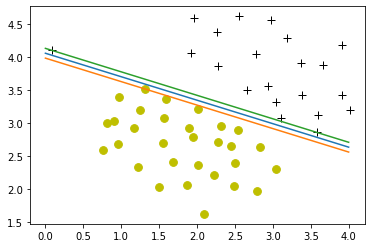

In [198]:
plotData2(X1, y1, sol)

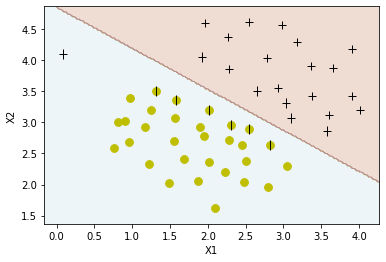

Number of support vectors:  12


In [199]:
clf = SVC(C=1, kernel='linear')
clf.fit(X1, y1.ravel())
plot_svc(clf, X1, y1)

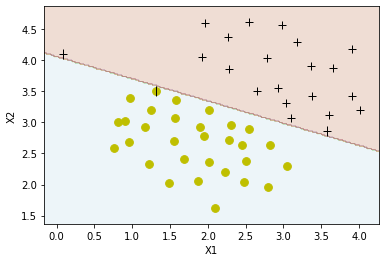

Number of support vectors:  3


In [200]:
clf = SVC(C = 100, kernel='linear')
clf.fit(X1, y1.ravel())
plot_svc(clf, X1, y1)

**Question.** Does the linear case work for C->0 and/or C->infinity work for the case that the dataset is not linearly separable? And what about the genetic code?
(Pull, e.g., the X1[50][1] -> 3, y1[50] = 1)
How would you rephrase the genetic optimization such that you could use it for the non separable case as well?

### SVM with other Kernels

Below are two more data sets. Use the package sklearn for this. Dive into the manual of this package an figure out how you can get a good classifier. Explain how the methods works with other kernels. Change parameters, such as C, degree and other basis functions: what is their effect? 

#### Example Dataset 2

In [2]:
data2 = loadmat('data/ex6data2.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
y2 = data2['y']
X2 = data2['X']

print('X2:', X2.shape)
print('y2:', y2.shape)

X2: (863, 2)
y2: (863, 1)


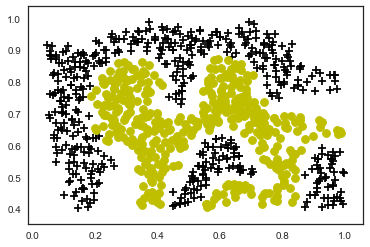

In [6]:
plotData(X2, y2)

#### Example Dataset 3

In [7]:
data3 = loadmat('data/ex6data3.mat')
data3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])

In [8]:
y3 = data3['y']
X3 = data3['X']

print('X3:', X3.shape)
print('y3:', y3.shape)

X3: (211, 2)
y3: (211, 1)


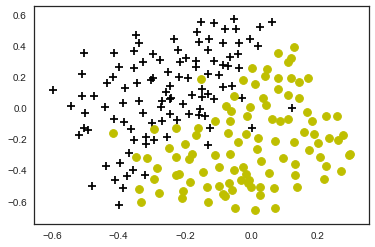

In [9]:
plotData(X3, y3)